# import 

In [58]:
import warnings
warnings.filterwarnings("ignore")

import os
import gc
import sys
import time
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import xgboost as xgb
import lightgbm as lgb
# import catboost as cat

from tqdm import tqdm_notebook
from multiprocessing import cpu_count
from scipy.stats import norm, entropy
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold

In [59]:
PATH = os.path.join('..', 'input')

 # read

In [60]:
train = pd.read_csv(os.path.join(PATH, 'train.csv'))
test = pd.read_csv(os.path.join(PATH, 'test.csv'))

# feature selection

In [61]:
kl = []
train_0 = train.query('target == 0')
train_1 = train.query('target == 1')
for c in train.columns[2:]:
    param_0 = norm.fit(train_0[c])
    param_1 = norm.fit(train_1[c])
    kl.append([c, entropy(param_0, param_1)])

kl = pd.DataFrame(kl, columns=['column', 'entropy'])

In [62]:
kl.describe()

,entropy
count,2.000000e+02
mean,inf
std,NaN
min,5.320802e-08
25%,1.995976e-05
50%,2.383566e-04
75%,8.473287e-03
max,inf


In [63]:
kl.sort_values('entropy')

,column,entropy
29,var_29,5.320802e-08
103,var_103,5.631154e-08
96,var_96,9.907548e-08
161,var_161,4.044650e-07
68,var_68,4.647036e-07
7,var_7,6.953198e-07
124,var_124,9.362053e-07
37,var_37,1.081624e-06
151,var_151,1.128935e-06
38,var_38,1.265450e-06


In [64]:
selected_kl = kl.query('entropy < 1.995976e-05').reset_index()['column'].values

# preprocess

In [65]:
y = train['target']

not_use_cols = ['ID_code', 'target'] 
# not_use_cols += list(selected_kl)
use_cols = [c for c in train.columns if c not in not_use_cols]

X = train[use_cols]
X_test = test[use_cols]

In [66]:
len(use_cols)

200

# Model 

## settings

In [67]:
SEED = 6

NFOLDS = 11

## params

In [68]:
params_in_train = {
    'num_boost_round': 10000,
    'early_stopping_rounds': 200,
    'verbose_eval': 500,
}

In [69]:
params = {
    'boosting': 'gbdt',
    'metric': 'auc',
    'objective': 'binary',
    'max_depth': -1,
    'num_leaves': 9,
    'min_data_in_leaf': 32,
    'bagging_freq': 5,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'sub_sample': 0.6,
    'reg_alpha': 2,
    'reg_lambda': 5,
    'min_gain_to_split': 0.01,
    'min_child_wight': 19,
    'num_threads': cpu_count(),
    'verbose': -1,
    'seed': SEED, # int(2**fold_n),
    'bagging_seed': SEED, # int(2**fold_n),
    'drop_seed': SEED, # int(2**fold_n),
}

## cv

In [70]:
kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

oof = np.zeros(len(X))
predictions = np.zeros(len(X_test))
scores = {'train': [], 'valid': []}
features = X.columns
feature_importance_df = pd.DataFrame(columns=['fold', 'feature', 'importance'])

for fold, (train_index, valid_index) in enumerate(kf.split(X, y)):
    print('fold: {}/{}'.format(fold+1, kf.n_splits))
    
    dtrain = lgb.Dataset(X.iloc[train_index], label=y.iloc[train_index])
    dvalid = lgb.Dataset(X.iloc[valid_index], label=y.iloc[valid_index])
    
    model = lgb.train(params, dtrain, valid_sets=[dtrain, dvalid], **params_in_train)
    scores['train'].append(model.best_score['training']['auc'])
    scores['valid'].append(model.best_score['valid_1']['auc'])
    oof[valid_index] = model.predict(X.iloc[valid_index], num_iteration=model.best_iteration)

    fold_feature_importance_df = pd.DataFrame(columns=['fold', 'feature', 'importance'])
    fold_feature_importance_df['feature'] = features
    fold_feature_importance_df['importance'] = model.feature_importance()
    fold_feature_importance_df['fold'] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_feature_importance_df], axis=0)

    predictions += model.predict(X_test, num_iteration=model.best_iteration) / NFOLDS

cv_score = roc_auc_score(y, oof)**0.5
print('Num folds: {}'.format(NFOLDS))
print('Train Scores: mean {:.5f}, max {:.5f}, min {:.5f}, std {:.5f}'.format(
    np.mean(scores['train']), np.max(scores['train']), np.min(scores['train']), np.std(scores['train'])))
print('Valid Scores: mean {:.5f}, max {:.5f}, min {:.5f}, std {:.5f}'.format(
    np.mean(scores['valid']), np.max(scores['valid']), np.min(scores['valid']), np.std(scores['valid'])))
print('CV Score: {:<8.5f}'.format(cv_score))

fold: 1/11
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.847329	valid_1's auc: 0.826552
[1000]	training's auc: 0.878996	valid_1's auc: 0.85501
[1500]	training's auc: 0.895013	valid_1's auc: 0.869145
[2000]	training's auc: 0.904714	valid_1's auc: 0.87789
[2500]	training's auc: 0.911519	valid_1's auc: 0.883117
[3000]	training's auc: 0.916742	valid_1's auc: 0.887372
[3500]	training's auc: 0.920688	valid_1's auc: 0.890262
[4000]	training's auc: 0.924036	valid_1's auc: 0.892695
[4500]	training's auc: 0.926764	valid_1's auc: 0.894685
[5000]	training's auc: 0.929114	valid_1's auc: 0.896029
[5500]	training's auc: 0.931116	valid_1's auc: 0.897079
[6000]	training's auc: 0.932906	valid_1's auc: 0.897921
[6500]	training's auc: 0.934548	valid_1's auc: 0.89853
[7000]	training's auc: 0.936242	valid_1's auc: 0.899028
[7500]	training's auc: 0.937896	valid_1's auc: 0.899303
[8000]	training's auc: 0.939502	valid_1's auc: 0.89959
Early stopping, best iteration is:


[5000]	training's auc: 0.929307	valid_1's auc: 0.894602
[5500]	training's auc: 0.93132	valid_1's auc: 0.89575
[6000]	training's auc: 0.933108	valid_1's auc: 0.896682
[6500]	training's auc: 0.934783	valid_1's auc: 0.89736
[7000]	training's auc: 0.936363	valid_1's auc: 0.897758
[7500]	training's auc: 0.938016	valid_1's auc: 0.898102
[8000]	training's auc: 0.93965	valid_1's auc: 0.898228
[8500]	training's auc: 0.941253	valid_1's auc: 0.898366
[9000]	training's auc: 0.942852	valid_1's auc: 0.898536
Early stopping, best iteration is:
[9120]	training's auc: 0.943222	valid_1's auc: 0.898579
fold: 9/11
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.846033	valid_1's auc: 0.833512
[1000]	training's auc: 0.877793	valid_1's auc: 0.862769
[1500]	training's auc: 0.893847	valid_1's auc: 0.877084
[2000]	training's auc: 0.904031	valid_1's auc: 0.885415
[2500]	training's auc: 0.911172	valid_1's auc: 0.890437
[3000]	training's auc: 0.916376	valid_1's auc: 0.893987


In [71]:
feature_importance_df.head()

,fold,feature,importance
0,1,var_0,448
1,1,var_1,542
2,1,var_2,471
3,1,var_3,155
4,1,var_4,153


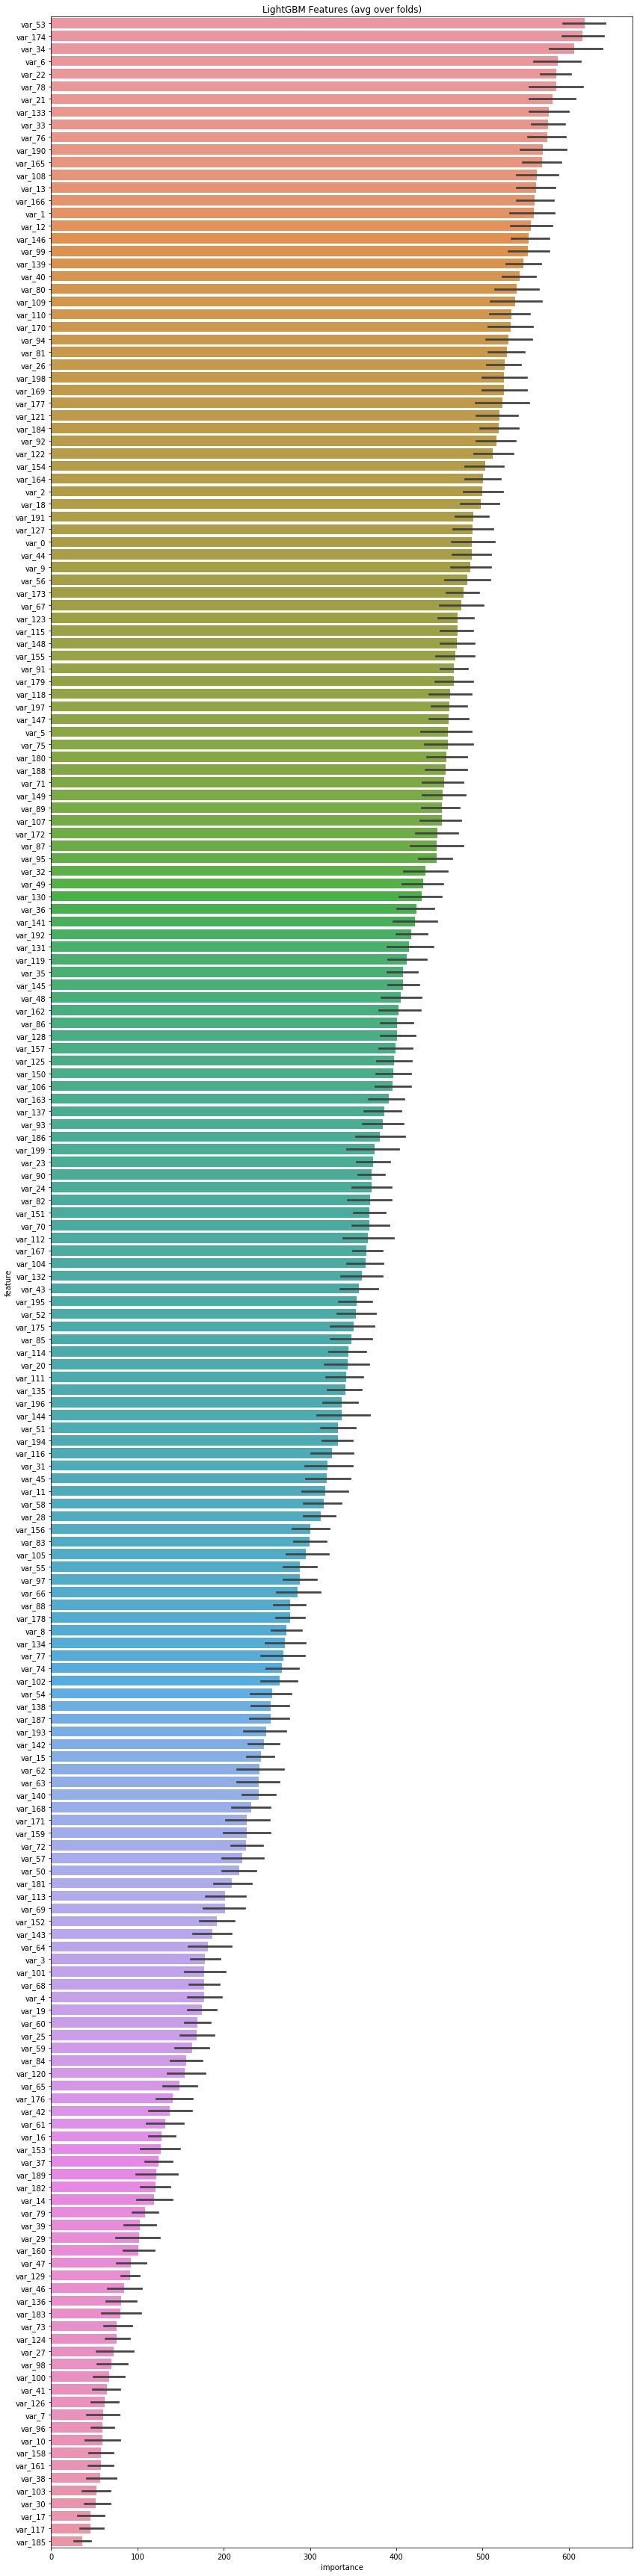

In [72]:
feature_importance_df['importance'] = feature_importance_df['importance'].astype('int')
mean = feature_importance_df['importance'].mean()
std = feature_importance_df['importance'].std()
width = 24
ordered_feature = feature_importance_df.groupby(['feature'])['importance'].mean().sort_values(ascending=False).index
plt.figure(figsize=(12, 48))
sns.barplot(x='importance', y='feature', data=feature_importance_df, order=ordered_feature)
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.vlines(mean, -width, width, colors='red')
# plt.vlines(mean+std, -width, width, colors='red', linestyles=':')
plt.show()

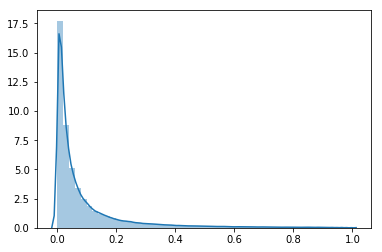

In [73]:
sns.distplot(predictions)
plt.show()

# submission

In [74]:
submission = pd.read_csv(os.path.join(PATH, 'sample_submission.csv'))

In [75]:
submission['target'] = predictions

In [76]:
submission.to_csv('../submission/lightgbm.csv', index=False)

In [108]:
# #!/usr/bin/env ptargetthon3
# # -*- coding: utf-8 -*-
# """
# Created on Mon Mar 4 2019

# @author: toshiki.ishikawa
# """
# import warnings
# warnings.simplefilter('ignore')

# import os
# import gc 
# import sys
# import datetime

# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import xgboost as xgb

# from tqdm import tqdm
# from collections import defaultdict
# from multiprocessing import cpu_count

# from sklearn.model_selection import StratifiedKFold, KFold 
# from sklearn.metrics import roc_auc_score

# #==============================================================================

# PATH = os.path.join('..', 'data')

# KEY = 'ID_code'

# SEED = 6
# # SEED = np.random.randint(9999)

# NTHREAD = cpu_count()

# NFOLDS = 2

# # =============================================================================
# # READ DATA
# # =============================================================================
# train = pd.read_csv(os.path.join(PATH, 'train.csv'))
# test = pd.read_csv(os.path.join(PATH, 'test.csv'))

# # =============================================================================
# # ADD HANDCRAFTED FEATURES
# # =============================================================================

# # =============================================================================
# # PREPROCESS
# # =============================================================================
# y = train['target']

# not_use_cols = ['ID_code', 'target'] 
# use_cols = [c for c in train.columns if c not in not_use_cols]

# X = train[use_cols]
# X_test = test[use_cols]

# # =============================================================================
# # PARAMS
# # =============================================================================
# params_in_train = {
#     'num_boost_round': 10000,
#     'early_stopping_rounds': 200,
#     'verbose_eval': 500,
# }

params = {
    'boosting': 'gbdt',
    'metric': 'auc',
    'objective': 'binary:logistic',
    'max_depth': 7,
    'num_leaves': 9,
    'min_data_in_leaf': 32,
    'bagging_freq': 5,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'sub_sample': 0.6,
    'reg_alpha': 2,
    'reg_lambda': 5,
    'min_gain_to_split': 0.01,
    'min_child_wight': 19,
    'num_threads': cpu_count(),
    'verbose': -1,
    'seed': SEED, # int(2**fold_n),
    'bagging_seed': SEED, # int(2**fold_n),
    'drop_seed': SEED, # int(2**fold_n),
}

# # =============================================================================
# # CV
# # =============================================================================
# skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

# oof = np.zeros(len(X))
# predictions = np.zeros(len(X_test))
scores = []
# features = X.columns
# feature_importance_df = pd.DataFrame(columns=['fold', 'feature', 'importance'])

for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
    print('fold: {}/{}'.format(fold+1, skf.n_splits))
    
    dtrain = xgb.DMatrix(data=X.iloc[train_index], label=y.iloc[train_index])
    dvalid = xgb.DMatrix(data=X.iloc[valid_index], label=y.iloc[valid_index])
    
    model = xgb.train(params, dtrain, evals=[(dtrain, 'train'), (dvalid, 'valid')], **params_in_train)
    oof[valid_index] = model.predict(dvalid, ntree_limit=model.best_ntree_limit)

    predictions += model.predict(xgb.DMatrix(data=X_test), ntree_limit=model.best_ntree_limit) / NFOLDS
    
    break
    
    del model

cv_score = roc_auc_score(y, oof)**0.5
print('Shape: {}'.format(X.shape))
print('Num folds: {}'.format(NFOLDS))
print('Scores: mean {:.5f}, max {:.5f}, min {:.5f}, std {:.5f}'.format(
    np.mean(scores), np.max(scores), np.min(scores), np.std(scores)))
print('CV Score: {:<8.5f}'.format(cv_score))

# cv_score = roc_auc_score(y, oof)**0.5
# print('Shape: {}'.format(X.shape))
# print('Num folds: {}'.format(NFOLDS))
# print('Train Scores: mean {:.5f}, max {:.5f}, min {:.5f}, std {:.5f}'.format(
#     np.mean(scores['train']), np.max(scores['train']), np.min(scores['train']), np.std(scores['train'])))
# print('Valid Scores: mean {:.5f}, max {:.5f}, min {:.5f}, std {:.5f}'.format(
#     np.mean(scores['valid']), np.max(scores['valid']), np.min(scores['valid']), np.std(scores['valid'])))
# print('CV Score: {:<8.5f}'.format(cv_score))

fold: 1/2
[0]	train-error:0.09575	valid-error:0.10306
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 200 rounds.
Stopping. Best iteration:
[48]	train-error:0.09866	valid-error:0.10025



ValueError: Found input variables with inconsistent numbers of samples: [200000, 100000]

In [93]:
model.attributes()

{'best_iteration': '48',
 'best_msg': '[48]\ttrain-error:0.09866\tvalid-error:0.10025',
 'best_score': '0.10025'}

In [98]:
model.get_score()

{'var_81': 339,
 'var_139': 473,
 'var_53': 401,
 'var_12': 452,
 'var_89': 189,
 'var_138': 67,
 'var_133': 283,
 'var_31': 100,
 'var_14': 87,
 'var_9': 257,
 'var_108': 324,
 'var_158': 59,
 'var_155': 133,
 'var_144': 66,
 'var_26': 495,
 'var_110': 472,
 'var_167': 106,
 'var_180': 89,
 'var_61': 105,
 'var_165': 360,
 'var_52': 71,
 'var_112': 81,
 'var_22': 443,
 'var_15': 72,
 'var_100': 73,
 'var_72': 90,
 'var_1': 291,
 'var_157': 108,
 'var_80': 427,
 'var_148': 418,
 'var_87': 169,
 'var_27': 37,
 'var_119': 91,
 'var_109': 360,
 'var_34': 324,
 'var_55': 86,
 'var_169': 250,
 'var_125': 123,
 'var_115': 245,
 'var_154': 276,
 'var_16': 65,
 'var_94': 305,
 'var_76': 421,
 'var_174': 450,
 'var_118': 221,
 'var_43': 76,
 'var_197': 99,
 'var_60': 66,
 'var_102': 54,
 'var_192': 203,
 'var_188': 118,
 'var_145': 129,
 'var_97': 48,
 'var_127': 209,
 'var_99': 474,
 'var_6': 557,
 'var_172': 180,
 'var_164': 291,
 'var_170': 304,
 'var_163': 101,
 'var_70': 72,
 'var_86': 227

In [110]:
scores.append(roc_auc_score(y.iloc[valid_index], oof[valid_index])**0.5)

In [111]:
scores

[0.844343890655458]